In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import minmax_scale
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    df.drop(cols, axis=1, inplace=True)
    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    return df

In [3]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
#df_test_trans = pd.read_csv('../input/test_transaction.csv')

df_train_identity = pd.read_csv('../input/train_identity.csv')
#df_test_identity = pd.read_csv('../input/test_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')
#df_test = df_test_trans.merge(df_test_identity, how='left', on='TransactionID')

print(df_train.shape)
#print(df_test.shape)

# Standardizing column names
df_train.columns = df_train.columns.str.replace('-', '_')
#df_test.columns = df_test.columns.str.replace('-', '_')

del df_train_trans, df_train_identity


(590540, 434)


In [4]:
# Reduce memory usage
df_train = reduce_mem_usage(df_train)
#df_test = reduce_mem_usage(df_test)

start_mem Memory usage of df_train: 2513.97 MB
Mem. usage decreased to 1204.57 Mb (52.1% reduction)


In [ ]:
for f in df_train.drop('isFraud', axis=1).columns:
     if df_train[f].dtype=='object': 
         lbl = preprocessing.LabelEncoder()
         lbl.fit(df_train[f].values)
         df_train[f] = lbl.transform(list(df_train[f].values))

df_train.fillna(-999, inplace=True)

X_train = df_train.select_dtypes(include=['number']).drop(columns=['isFraud'])
y_train = df_train['isFraud']  # This is the target variable

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Apply StandardScaler (fit only on train, transform on both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

# Initialize PCA and specify number of components (optional)
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

Validation Accuracy: 0.97
Validation Precision: 0.90
Validation Recall: 0.24
Validation F1 Score: 0.38

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99    113866
           1       0.90      0.24      0.38      4242

    accuracy                           0.97    118108
   macro avg       0.93      0.62      0.68    118108
weighted avg       0.97      0.97      0.96    118108



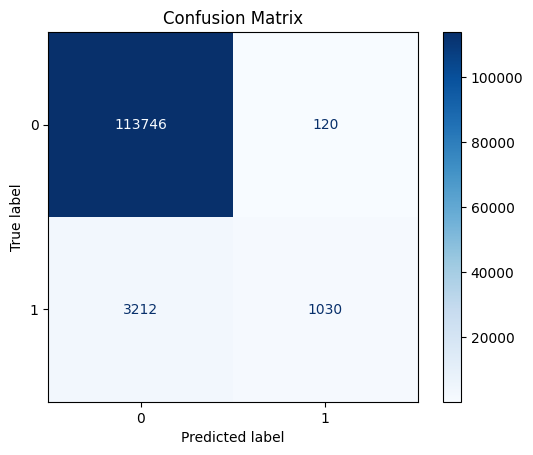

In [6]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train_pca, y_train_final)

# Make Predictions
y_val_pred = rf.predict(X_val_pca)

# Compute Metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Print results
print(f"Validation Accuracy: {accuracy:.2f}")
print(f"Validation Precision: {precision:.2f}")
print(f"Validation Recall: {recall:.2f}")
print(f"Validation F1 Score: {f1:.2f}")

# Show detailed classification report
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Toto dalsie sluzi len na porovnanie ako som to robil, je tam viacero chyb

In [14]:
df_test['isFraud'] = 'test'
df = pd.concat([df_train, df_test], axis=0, sort=False )
df = df.reset_index()
df = df.drop('index', axis=1)

mas_v = df_train.columns[55:394]

for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1))) #toto musim zmenit lebo to je pre XGBoost dobre

df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=30)

df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)
df_train.shape

C:\Users\Marek\AppData\Local\Temp\ipykernel_26316\3305452335.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test['isFraud'] = 'test'


(590540, 125)

In [15]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 
                                                      'TransactionDT', 
                                                      #'Card_ID'
                                                     ],
                                                     axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT',
                                                    #'Card_ID'
                                                   ], 
                                                   axis=1)
del df_train
test = df_test[["TransactionDT"]]

In [9]:
print(X_train.columns.tolist())

['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'PCA_V_0', 'PCA_V_1', 'PCA_V_2', 'PCA_V_3', 'PCA_V_4', 'PCA_V_5', 'PCA_V_6', 'PCA_V_7', 'PCA_V_8', 'PCA_V_9', 'PCA_V_10', 'PCA_V_11', 'PCA_V_12', 'PCA_V_13', 'PCA_V_14', 'PCA_V_15', 'PCA_V_16', 'PCA_V_17', 'PCA_V_18', 

In [17]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees
    'max_depth': [10, 20, 30],        # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples needed to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples per leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Initialize the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, 
    scoring='roc_auc', cv=2, verbose=3, n_jobs=-1
)

total_combinations = np.prod([len(v) for v in param_grid.values()])

# Fit on training data
with tqdm(total=total_combinations) as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(total_combinations)

# Get the best parameters
best_rf_params = grid_search.best_params_
print("\nBest Hyperparameters:", best_rf_params)

# Train the optimized Random Forest model
final_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
final_rf.fit(X_train, y_train)

# Predictions on training data
y_pred = final_rf.predict(X_train)
y_pred_proba = final_rf.predict_proba(X_train)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
roc_auc = roc_auc_score(y_train, y_pred_proba)
conf_matrix = confusion_matrix(y_train, y_pred)

# Print Metrics
print("\nFinal Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


  0%|          | 0/162 [00:00<?, ?it/s]

Fitting 2 folds for each of 162 candidates, totalling 324 fits


  0%|          | 0/162 [4:01:02<?, ?it/s]


KeyboardInterrupt: 

toto spodne je zatial pokusne

In [27]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
}

In [29]:
# Set algoritm parameters
# Run Hyperopt tuning
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=25, trials=trials)

# Print best parameters
best_params = space_eval(space, best)

                                                      
############## New Run ################
params = {'max_depth': 7, 'gamma': '0.688', 'subsample': '0.40', 'reg_alpha': '0.388', 'reg_lambda': '0.020', 'learning_rate': '0.031', 'colsample_bytree': '0.320'}
1 CV - score: 0.6726                                  
2 CV - score: 0.6652                                  
3 CV - score: 0.7154                                  
4 CV - score: 0.6563                                  
5 CV - score: 0.7128                                  
6 CV - score: 0.6598                                  
7 CV - score: 0.6588                                  
Total Time Run: 4.8                                   
Mean ROC_AUC: 0.677278002328681                       
                                                                                   
############## New Run ################
params = {'max_depth': 16, 'gamma': '0.355', 'subsample': '0.90', 'reg_alpha': '0.064', 'reg_lambda': '0.014', 'learning_

KeyboardInterrupt: 